In [1]:
import sys
import os
# Get the current working directory
current_dir = os.getcwd()
# Add the parent directory of 'scrapping' to the system path
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'scrapping')))
from text_cleaner import read_and_clean_adrs

from nltk.corpus import stopwords
from markdown2 import markdown
import openai
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance, OpenAI
from sentence_transformers import SentenceTransformer
from bertopic.representation import KeyBERTInspired
import datamapplot
import pandas as pd
import seaborn

import warnings
warnings.filterwarnings('ignore')

# load environment variables
from dotenv import load_dotenv
load_dotenv()

# Path to the ADR directory
adr_directory = "../../data/ADRs-Updated"

In [2]:
with open("outlier_documents.txt") as f:
    outlier_documents = f.read().splitlines()

In [4]:
prompt = """
I have a topic that contains the following documents: 
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <topic label>
the topic label must be at most 5 words long strictly. The documents are related to software development. They are architectural
decision records (ADRs) that describe the decisions made in the development of software systems. The keywords are extracted from the documents.
The topic labels should be general enough but will need to differantiate between
decision categories. Those are outlier documents from a previous run.
"""

# GPT as representation model ~0.10$ per run
client = openai.OpenAI(api_key=os.getenv("OPEN_AI_API_KEY"))
open_ai_repr_model = OpenAI(client, model="gpt-3.5-turbo", chat=True, prompt=prompt, tokenizer="vectorizer")

In [20]:
# The main representation of a topic
# Use a KeyBERT-like model to fine-tune the topic representations
# The algorithm follows KeyBERT but does some optimization in order to speed up inference.
keybert_repr = KeyBERTInspired()

# Add all models together to be run in a single `fit`
representation_model = {
   "Main": keybert_repr,
   "Keywords":  keybert_repr,
}

In [6]:
# create a list of embeddings
embedding_model = SentenceTransformer("all-mpnet-base-v2")
outlier_embeddings = embedding_model.encode(outlier_documents, show_progress_bar=True)

Batches:   0%|          | 0/24 [00:00<?, ?it/s]

In [8]:
from umap import UMAP
from hdbscan import HDBSCAN

# A higher min_cluster_size will generate fewer topics and a lower min_cluster_size will generate more topics.
# here we go lower to dive deep into the outliers
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [9]:
bert_topic_1 = BERTopic(
                        # hyperparameters 
                        language="english", # language of the documents
                        # nr_topics=10, # number of topics to output (this reduces topic AFTER they have been discovered)
                        top_n_words=10, # number of top words per topic
                        n_gram_range=(1, 2), # number of words per n-gram (n_grams are phrases of n words)
                        min_topic_size=12,  # minimum number of data points per topic (more = less topics)
                        # models and embeddings
                        umap_model=umap_model, 
                        hdbscan_model=hdbscan_model,
                        representation_model=representation_model,
                        embedding_model=embedding_model,
                        # other
                        calculate_probabilities=True, # calculate the probs of a document belonging to a topic (slows down training, use when good results are found)
                        )
topics, probs = bert_topic_1.fit_transform(outlier_documents)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
bert_topic_1.visualize_documents(outlier_documents, embeddings=outlier_embeddings)

In [11]:
bert_topic_1.get_topic_info()

,Topic,Count,Name,Representation,Keywords,Representative_Docs
0,-1,211,-1_Composite Action Decisions,[Composite Action Decisions],"[workflow, implement, implementation, project,...",[multitenancy approach marain tenancy always f...
1,0,72,0_Web Backend Framework Decision,[Web Backend Framework Decision],"[web framework, django, backend, frontend, api...",[ruby new application manage offender custody ...
2,1,51,1_Build System Decisions,[Build System Decisions],"[maven deploy, apache maven, maven, configurat...",[architecture record persistent configuration ...
3,2,51,2_payment flow architecture,[payment flow architecture],"[payment method, payment key, payment, payment...",[add paypal supported payment deciders ben ban...
4,3,40,3_Raster Map Algebra Operations,[Raster Map Algebra Operations],"[drawing tool, drawing, raster foundry, raster...",[see httpsgithubcomazavearasterfoundryissues f...
5,4,38,4_Tenant Onboarding Architecture,[Tenant Onboarding Architecture],"[application architecture, service tenant, end...",[evaluation resilience framework general frame...
6,5,33,5_Time Handling Decisions,[Time Handling Decisions],"[time field, datetime, utc timestamps, timesta...",[timestamp format content summary issue detail...
7,6,32,6_Software Change Influence,[Software Change Influence],"[agreed implement, implement, motivating influ...",[standalone prometheus issue motivating influe...
8,7,28,7_screen architecture decision records,[screen architecture decision records],"[screen architecture, current architecture, si...",[adr screen architecture superceded current sc...
9,8,27,8_caching strategy decision,[caching strategy decision],"[caching, cache, cache setting, memcached, cac...",[cedar caching user story easi easi heavily re...


In [21]:
new_topics = bert_topic_1.reduce_outliers(outlier_documents, topics, probabilities=probs, 
                             threshold=0.05, strategy="probabilities")
# add representation model if needed
bert_topic_1.update_topics(outlier_documents, topics=new_topics, representation_model=representation_model)

2024-06-18 16:31:08,145 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [22]:
bert_topic_1.visualize_documents(outlier_documents, embeddings=outlier_embeddings)

In [36]:
bert_topic_1.get_topic_info()

,Topic,Count,Name,Representation,Keywords,Representative_Docs
0,-1,77,-1_api_routing engine_firebase_endpoint,"[api, routing engine, firebase, endpoint, impl...","[api, routing engine, firebase, endpoint, impl...",[multitenancy approach marain tenancy always f...
1,0,81,0_web framework_backend_django_api,"[web framework, backend, django, api, frontend...","[web framework, backend, django, api, frontend...",[ruby new application manage offender custody ...
2,1,76,1_build tool_implementation_configuration_depe...,"[build tool, implementation, configuration, de...","[build tool, implementation, configuration, de...",[architecture record persistent configuration ...
3,2,53,2_payment method_payment key_payment_payment s...,"[payment method, payment key, payment, payment...","[payment method, payment key, payment, payment...",[add paypal supported payment deciders ben ban...
4,3,52,3_pdf file_raster_raster foundry_imagery,"[pdf file, raster, raster foundry, imagery, cl...","[pdf file, raster, raster foundry, imagery, cl...",[see httpsgithubcomazavearasterfoundryissues f...
5,4,64,4_service tenant_tenant workflow_client tenant...,"[service tenant, tenant workflow, client tenan...","[service tenant, tenant workflow, client tenan...",[evaluation resilience framework general frame...
6,5,33,5_time field_datetime_utc timestamps_timestamps,"[time field, datetime, utc timestamps, timesta...","[time field, datetime, utc timestamps, timesta...",[timestamp format content summary issue detail...
7,6,32,6_agreed implement_implement_motivating influe...,"[agreed implement, implement, motivating influ...","[agreed implement, implement, motivating influ...",[standalone prometheus issue motivating influe...
8,7,28,7_screen architecture_current architecture_sin...,"[screen architecture, current architecture, si...","[screen architecture, current architecture, si...",[adr screen architecture superceded current sc...
9,8,28,8_caching_cache_cache setting_memcached,"[caching, cache, cache setting, memcached, cac...","[caching, cache, cache setting, memcached, cac...",[cedar caching user story easi easi heavily re...


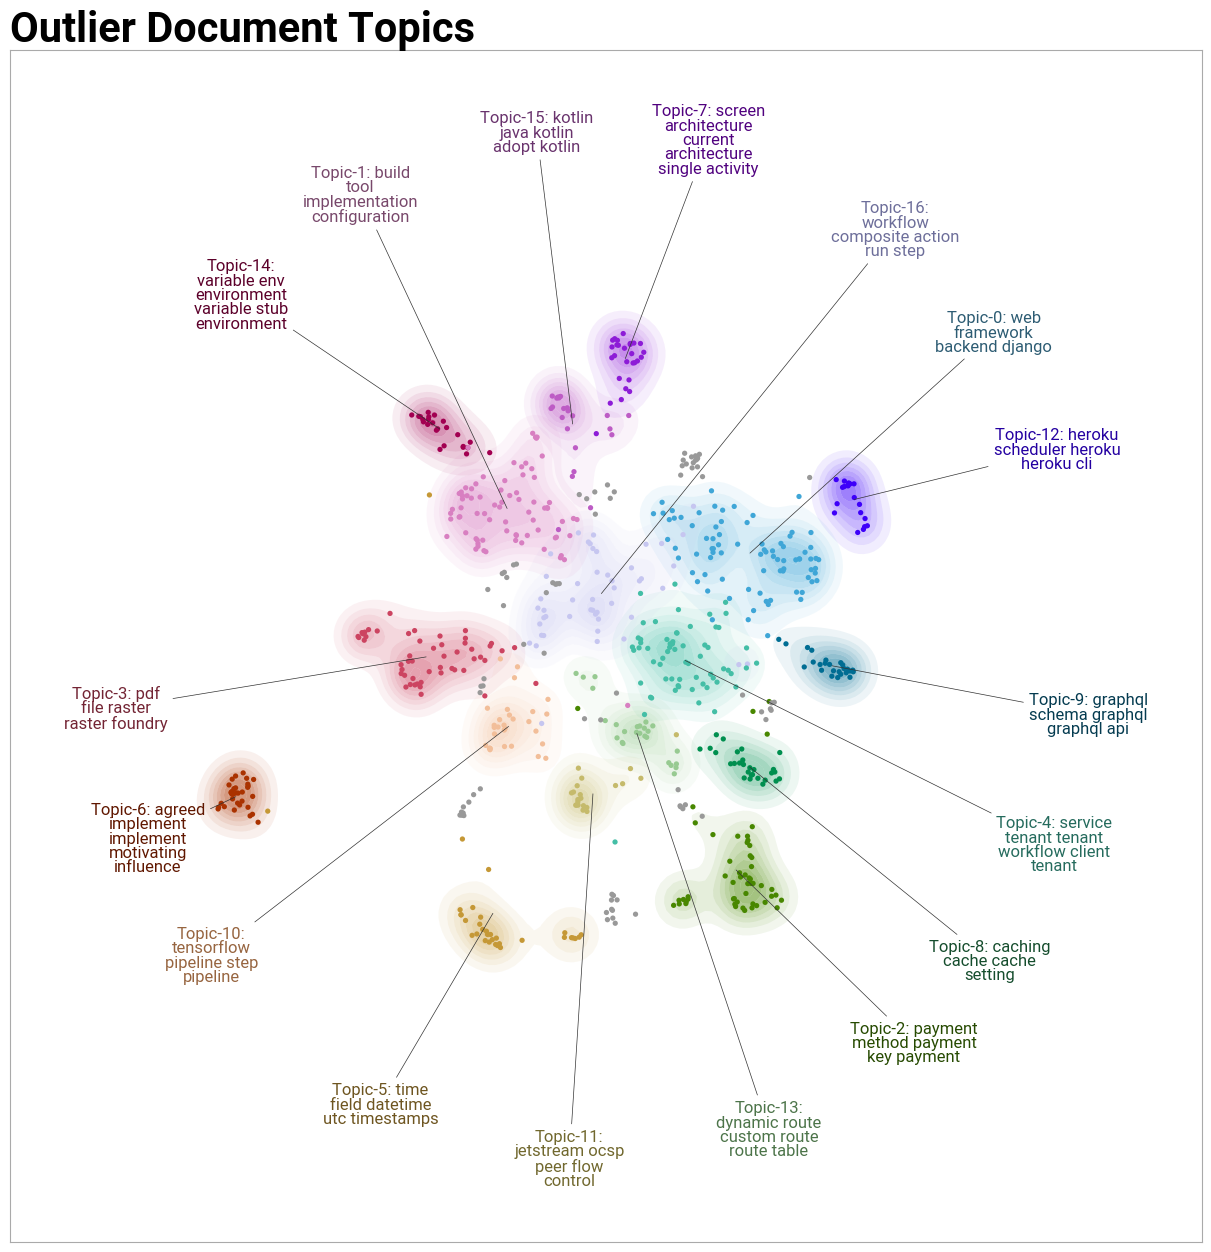

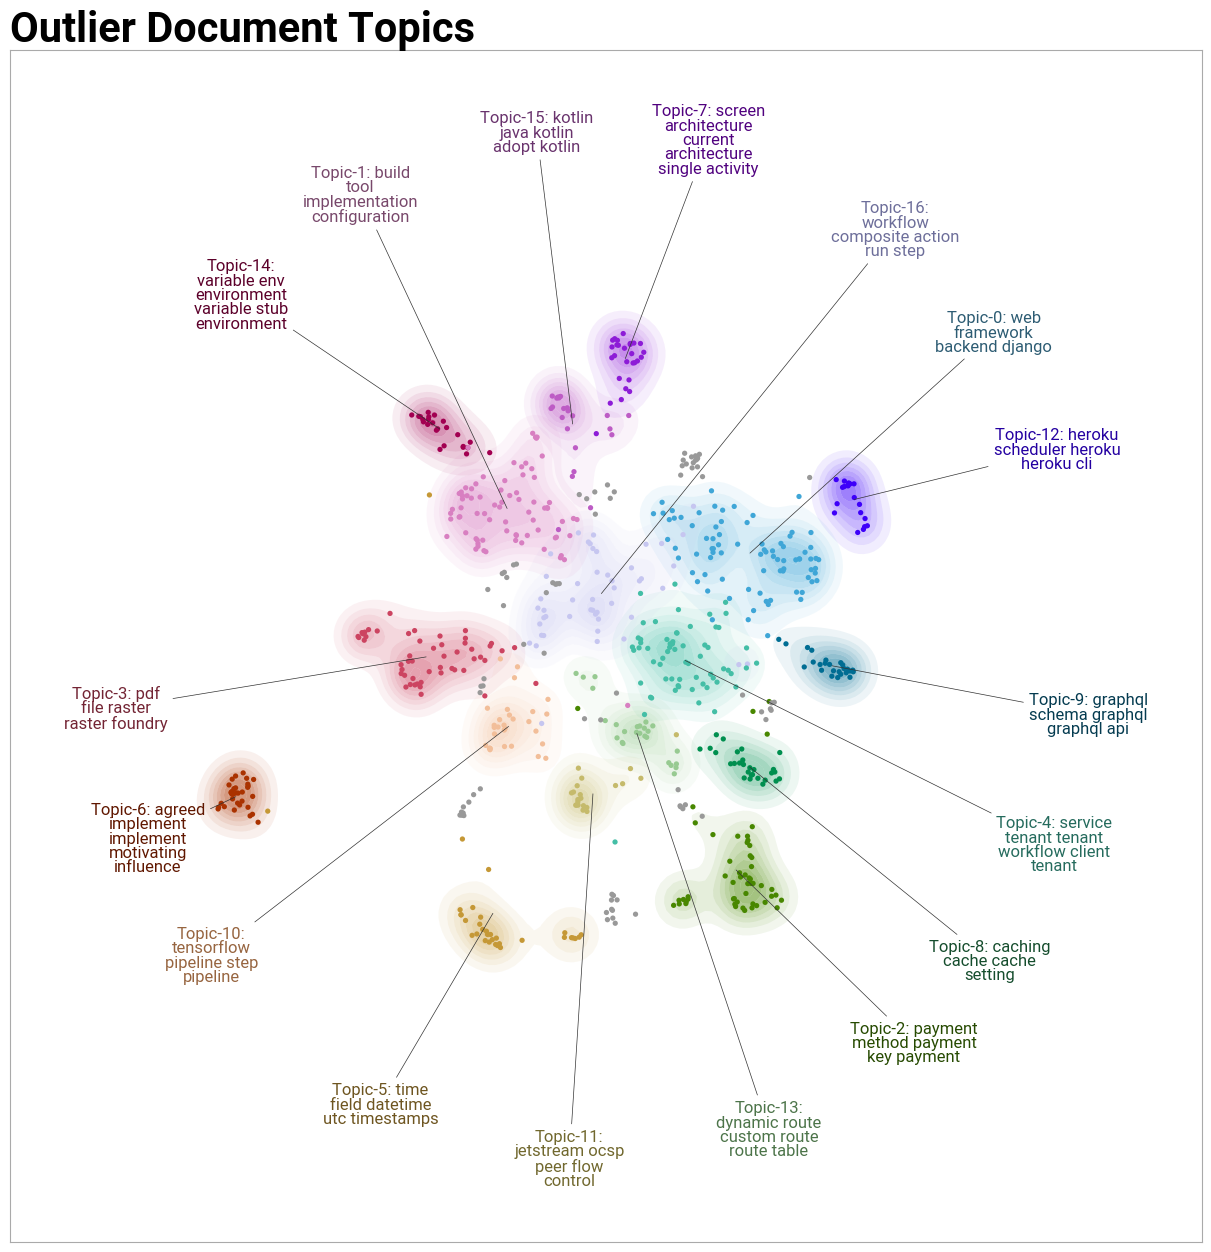

In [ ]:
title_keywords={"fontsize": 30}

datamap_args = {
    "title_keywords": title_keywords,
    "label_font_size" : 12
}

bert_topic_1.visualize_document_datamap(outlier_documents, embeddings=outlier_embeddings, **datamap_args, title="Outlier Document Topics")